In [39]:
# Metrics and plots from Hands-on Machine Learning with Scikit-learn, Keras and Tensorflow

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from tabulate import tabulate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score,
                             precision_recall_curve, roc_curve)
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier,
                              ExtraTreesClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from model import _column_transformer

df = pd.read_csv('train.csv')
X = df.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'])
y = df['Survived']
column_transformer = _column_transformer(X.columns)

ada_boost = AdaBoostClassifier()
gradient_boosting = GradientBoostingClassifier()
random_forest = RandomForestClassifier()
extra_tree = ExtraTreesClassifier()
k_neighbors = KNeighborsClassifier()
svc = SVC(kernel='poly')
logistic_regression = LogisticRegression(max_iter=1000)
classifiers = [ada_boost, gradient_boosting, random_forest, extra_tree, k_neighbors, svc, logistic_regression]

# Calculate predictions and scores
preds_and_scores = dict()
for clf in classifiers:
    pipeline = make_pipeline(column_transformer, clf)
    y_pred = cross_val_predict(pipeline, X, y, cv=3)
    if hasattr(clf, 'decision_function'):
        y_scores = cross_val_predict(pipeline, X, y, cv=3, method='decision_function')
    else:
        y_scores = cross_val_predict(pipeline, X, y, cv=3, method='predict_proba')
        y_scores = y_scores[:, 1]  # Get only positive cases
    preds_and_scores[type(clf).__name__] = [y_pred, y_scores]

In [40]:
# Metrics
headers = ['Precision', 'Recall', 'F1 score', 'ROC AUC score', 'TN', 'FN', 'TP', 'FP']
rows = []
for clf in classifiers:
    y_pred, y_scores = preds_and_scores[type(clf).__name__]
    cm = confusion_matrix(y, y_pred).tolist()
    rows.append([
        type(clf).__name__,
        roc_auc_score(y, y_scores),
        precision_score(y, y_pred),
        recall_score(y, y_pred),
        f1_score(y, y_pred),
        cm[0][0], cm[0][1], cm[1][1], cm[1][0],])
rows.sort(key=lambda row: row[1], reverse=True)  
display(HTML(tabulate(rows, headers=headers, tablefmt='html')))

,Precision,Recall,F1 score,ROC AUC score,TN,FN,TP,FP
GradientBoostingClassifier,0.852502,0.789298,0.690058,0.736349,486,63,236,106
RandomForestClassifier,0.843352,0.740854,0.710526,0.725373,464,85,243,99
LogisticRegression,0.843104,0.751613,0.681287,0.714724,472,77,233,109
AdaBoostClassifier,0.837994,0.734694,0.736842,0.735766,458,91,252,90
ExtraTreesClassifier,0.814202,0.726727,0.707602,0.717037,458,91,242,100
KNeighborsClassifier,0.78716,0.691318,0.628655,0.658499,453,96,215,127
SVC,0.759294,0.78125,0.0730994,0.13369,542,7,25,317


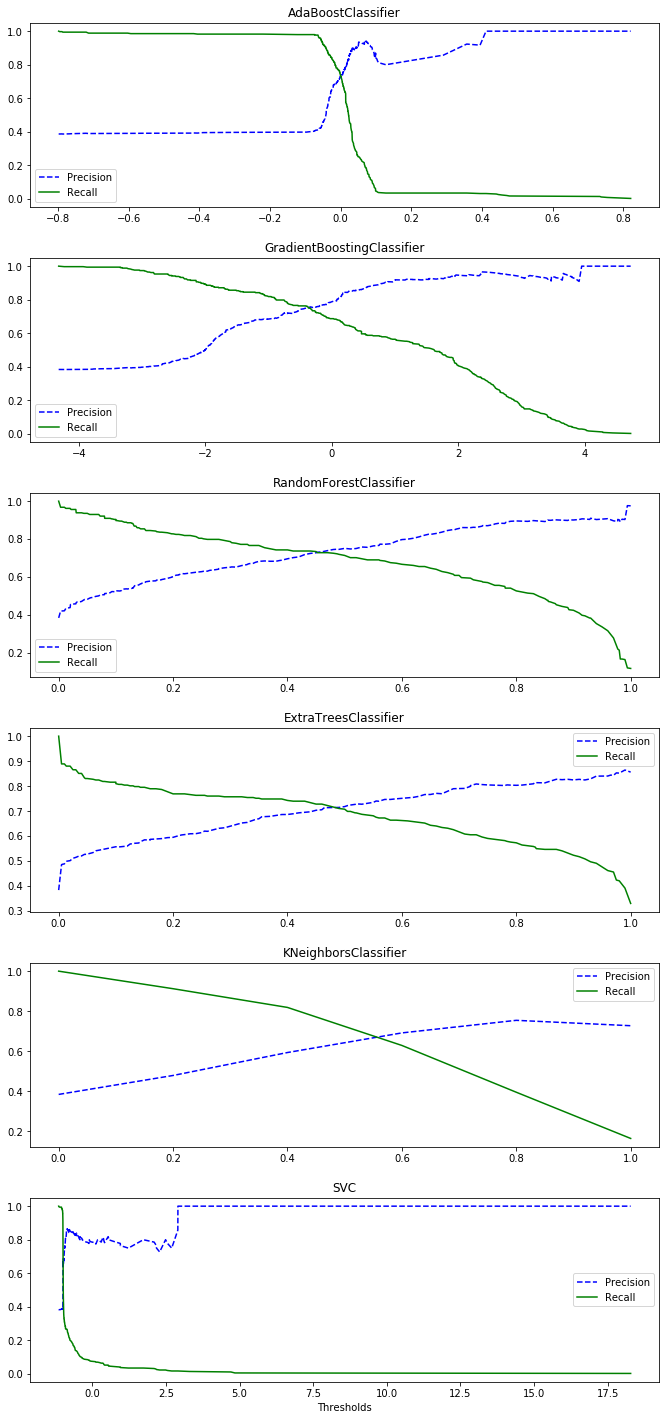

In [25]:
# Precision x recall
fig, axs = plt.subplots(len(classifiers), figsize=(10, 20))
fig.tight_layout(pad=3.0)
plt.xlabel('Thresholds')
for i, clf in enumerate(classifiers):
    _, y_scores = preds_and_scores[type(clf).__name__]
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    axs[i].plot(thresholds, precisions[:-1], 'b--', label='Precision')
    axs[i].plot(thresholds, recalls[:-1], 'g-', label='Recall')
    axs[i].legend()
    axs[i].set_title(type(clf).__name__)

`SVC` is good at finding true negatives but very at bad true positives - it is just predicting more negatives than the others, as can be seen by on its `Precision x Recall` plot. `GradientBoostingClassifier` gets the most true negatives (deaths) while `AdaBoostClassifier` gets the most true positives (survivals). `GradientBoostingClassifier` has the better precision while `AdaBoostClassifier` has the best recall and their F1 score is basically the same. `GradientBoostingClassifier` has the best ROC AUC.

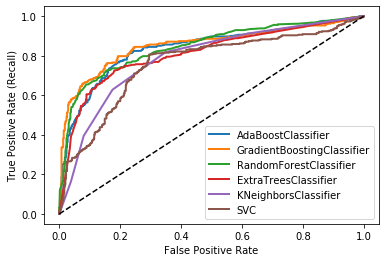

In [26]:
# ROC curves
for clf in classifiers:
    _, y_scores = preds_and_scores[type(clf).__name__]
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=type(clf).__name__)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)');